[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Date,PETR4.SA,BBAS3.SA,ABEV3.SA,WEGE3.SA
0,2010-01-04,10.659331,2.389993,3.638693,2.039934
1,2010-01-05,10.567934,2.366014,3.660099,2.035483
2,2010-01-06,10.710745,2.369210,3.697436,2.046612
3,2010-01-07,10.610778,2.370010,3.714797,2.081112
4,2010-01-08,10.553653,2.383599,3.707661,2.156788
...,...,...,...,...,...
3553,2024-04-26,39.914928,27.379999,12.010000,39.220001
3554,2024-04-29,40.394100,27.549999,12.100000,39.360001
3555,2024-04-30,40.269516,27.420000,12.150000,39.549999
3556,2024-05-02,40.422848,27.709999,12.330000,38.849998


Carteira de Minimum Volatility:
      Ativo  Quantidade
0  PETR4.SA        0.55
1  BBAS3.SA        0.09
2  ABEV3.SA        0.05
3  WEGE3.SA        0.31

Carteira de Maximum Sharpe Ratio:
      Ativo  Quantidade
0  PETR4.SA        0.00
1  BBAS3.SA        0.33
2  ABEV3.SA        0.00
3  WEGE3.SA        0.67


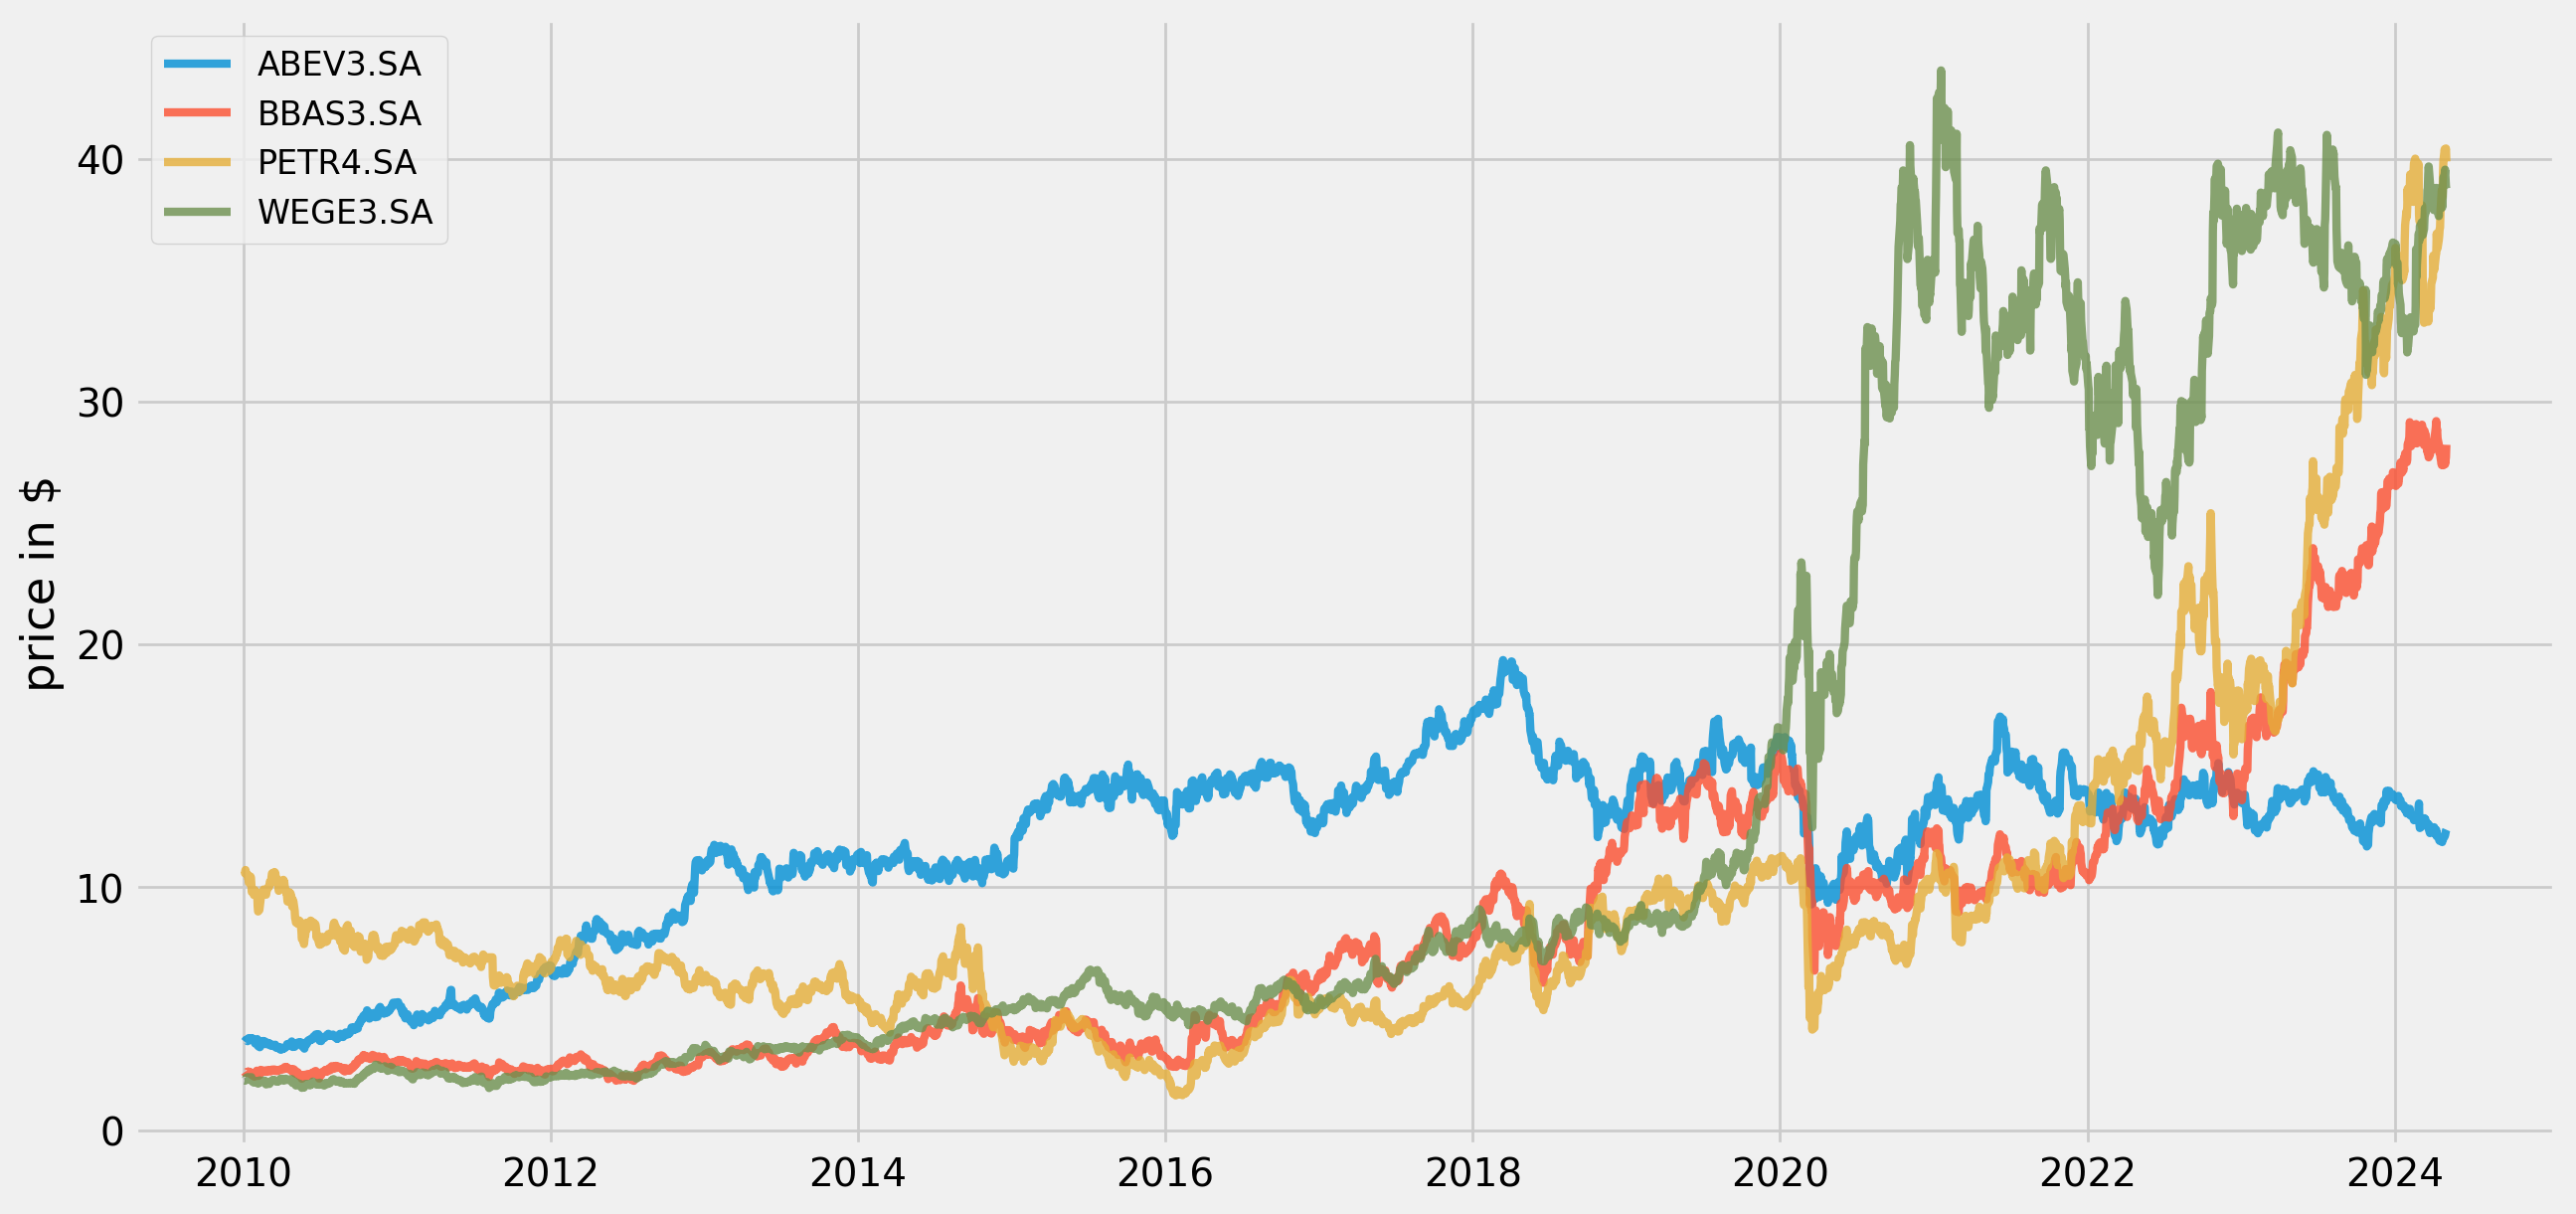

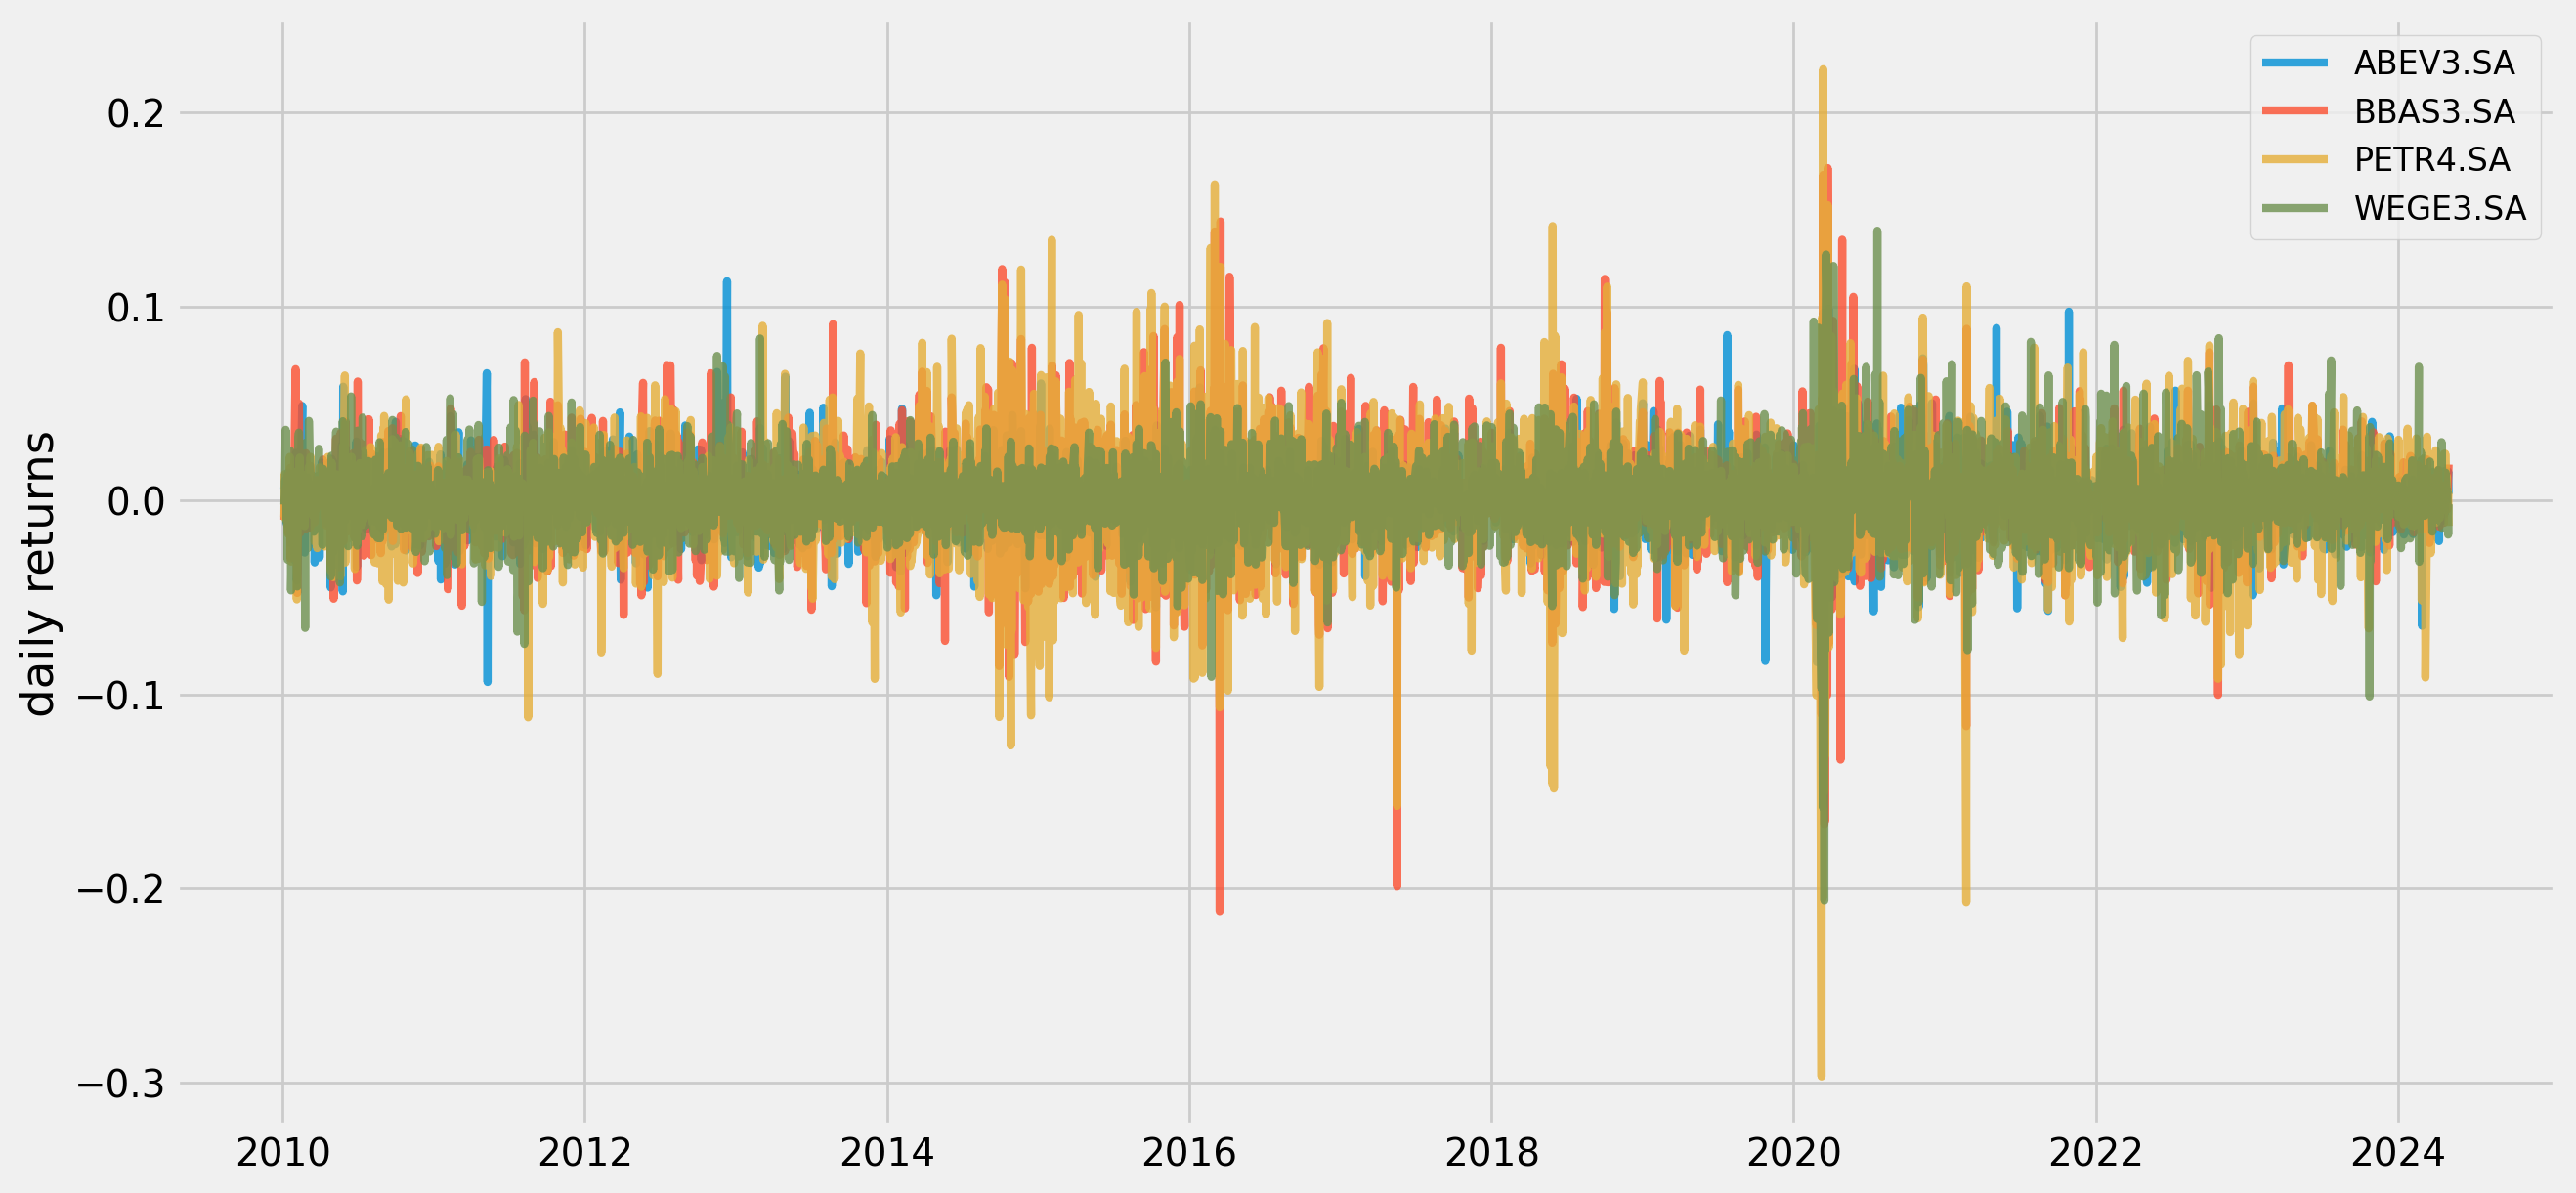

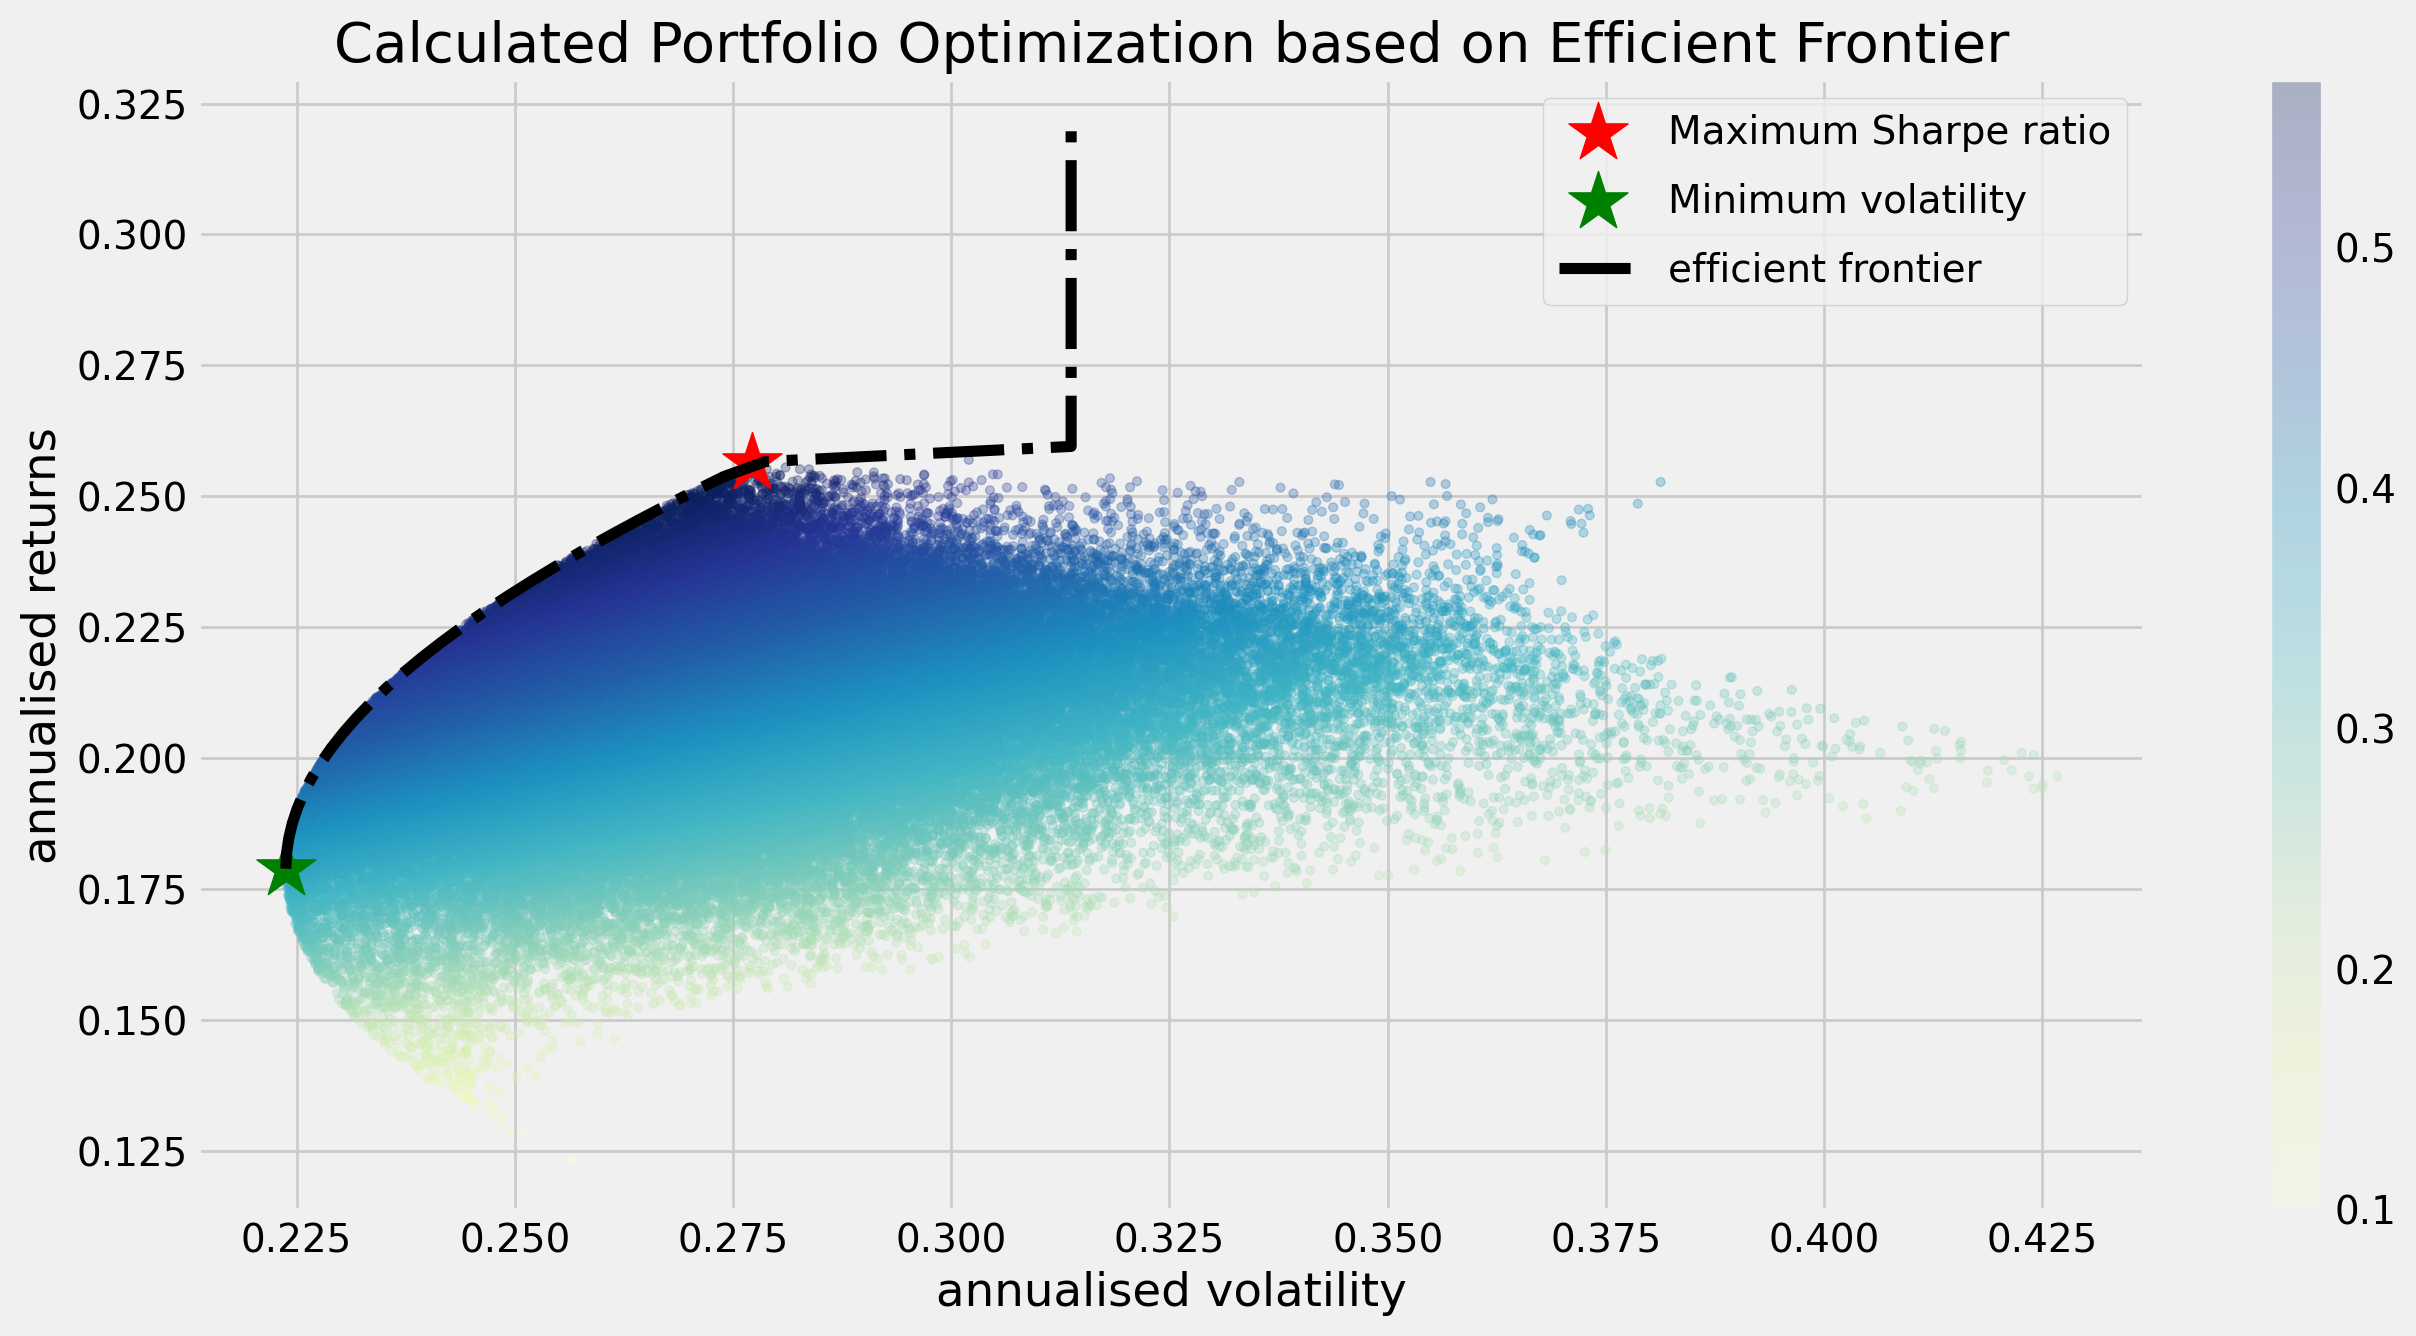

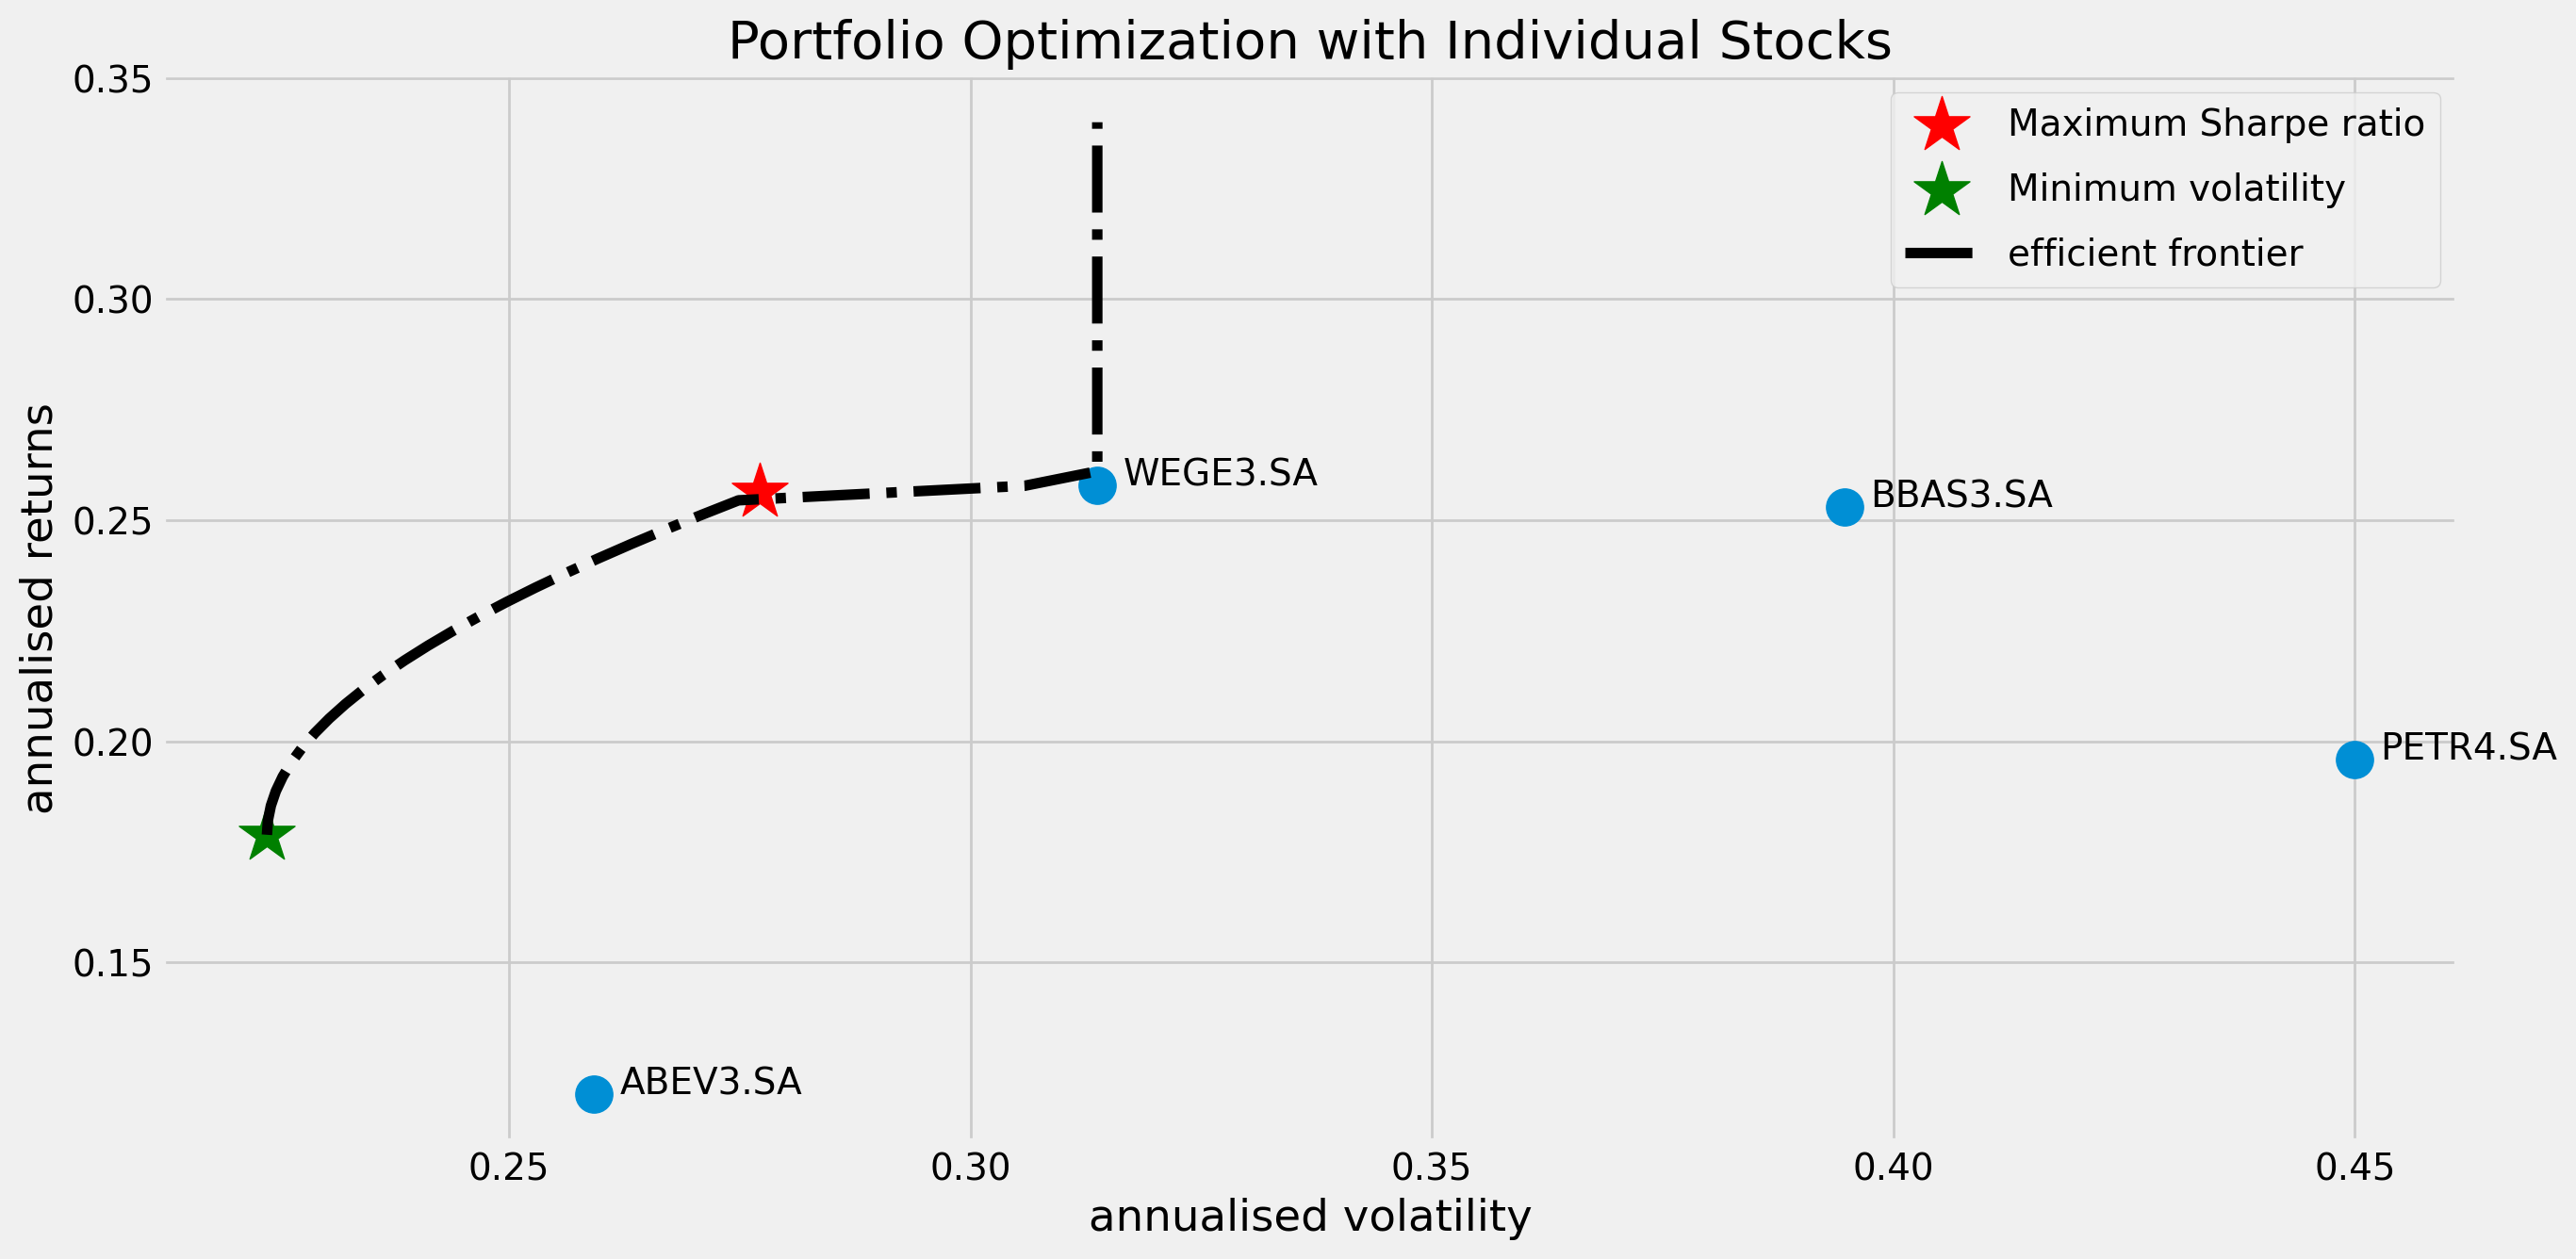

In [1]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as sco
import yfinance as yf
import warnings

warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')
np.random.seed(777)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

tickers = ['PETR4.SA','BBAS3.SA','ABEV3.SA','WEGE3.SA']

data = {}

for ticker in tickers:
    data[ticker] = yf.download(ticker, start='2010-01-02')['Adj Close']
    
df = pd.DataFrame(data)

df.reset_index(inplace=True)

display(df)
table = pd.pivot_table(df, index='Date', aggfunc='mean')

plt.figure(figsize=(14, 7))
for c in table.columns.values:
    plt.plot(table.index, table[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')

returns = table.pct_change()
plt.figure(figsize=(14, 7))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('daily returns')

def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns
  
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):  # Change xrange to range
        weights = np.random.random(len(tickers))
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

returns = table.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 100000
risk_free_rate = 0.10

constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

def portfolio_volatility(weights, mean_returns, cov_matrix):return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result

def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result


def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

def display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, _ = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    plt.figure(figsize=(14, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.32, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    plt.title('Calculated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

def display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate):
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    an_vol = np.std(returns) * np.sqrt(252)
    an_rt = mean_returns * 252
    
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.scatter(an_vol,an_rt,marker='o',s=200)

    for i, txt in enumerate(table.columns):
        ax.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')
    ax.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    ax.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.34, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    ax.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    ax.set_title('Portfolio Optimization with Individual Stocks')
    ax.set_xlabel('annualised volatility')
    ax.set_ylabel('annualised returns')
    ax.legend(labelspacing=0.8)

def max_sharpe_ratio_with_allocation(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result, result['x']

def min_variance_with_allocation(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result, result['x']

display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate)

# Chamadas das funções
max_sharpe_result, max_sharpe_allocation = max_sharpe_ratio_with_allocation(mean_returns, cov_matrix, risk_free_rate)
min_vol_result, min_vol_allocation = min_variance_with_allocation(mean_returns, cov_matrix)
# Lista de ativos (tickers)
ativos = df.columns.tolist()
# Removendo as datas da lista de ativos
ativos = [ativo for ativo in ativos if ativo != 'Date']
# Lista de tuplas contendo nome do ativo e quantidade alocada para a carteira de minimum volatility
min_vol_allocation_tuples = [(ativo, quantidade) for ativo, quantidade in zip(ativos, min_vol_allocation)]
# Lista de tuplas contendo nome do ativo e quantidade alocada para a carteira de maximum Sharpe ratio
max_sharpe_allocation_tuples = [(ativo, quantidade) for ativo, quantidade in zip(ativos, max_sharpe_allocation)]
# Criando DataFrame para a carteira de minimum volatility
df_min_vol_allocation = pd.DataFrame(min_vol_allocation_tuples, columns=['Ativo', 'Quantidade'])
df_min_vol_allocation['Ativo'] = df_min_vol_allocation['Ativo'].str.upper()  # Convertendo os tickers para maiúsculas
# Criando DataFrame para a carteira de maximum Sharpe ratio
df_max_sharpe_allocation = pd.DataFrame(max_sharpe_allocation_tuples, columns=['Ativo', 'Quantidade'])
df_max_sharpe_allocation['Ativo'] = df_max_sharpe_allocation['Ativo'].str.upper()  # Convertendo os tickers para maiúsculas
print("Carteira de Minimum Volatility:")
print(round(df_min_vol_allocation,2))
print("\nCarteira de Maximum Sharpe Ratio:")
print(round(df_max_sharpe_allocation,2))